# SciPy

## Outline

* [Scipy versus Numpy](#Outline 1)    
* [Statistics](#Outline 2)    
* [Roots and Fixed Points](#Outline 3)    
* [Optimization](#Outline 4)   
* [Integration](#Outline 5)    
* [Linear Algebra](#Outline 6)    
* [Exercise](#Outline 7)

## <div id="Outline 1"></div>SciPy versus NumPy

- SciPy provides common tools for scientific programming, such as    
>- [linear algebra](https://docs.scipy.org/doc/scipy/reference/linalg.html)        
>- [numerical integration](https://docs.scipy.org/doc/scipy/reference/integrate.html)        
>- [interpolation](https://docs.scipy.org/doc/scipy/reference/interpolate.html)    
>- [optimization](https://docs.scipy.org/doc/scipy/reference/optimize.html)    
>- [distributions and random number generation](https://docs.scipy.org/doc/scipy/reference/stats.html)    
>- [signal processing](https://docs.scipy.org/doc/scipy/reference/signal.html)    
>- etc., etc

- SciPy is a package that contains various tools that are built on top of NumPy, using its array data type and related functionality    
In fact, when we import SciPy we also get NumPy    
However, it’s more common and better practice to use NumPy functionality explicitly

In [ ]:
import numpy as np

a = np.identity(3)

- What is useful in SciPy is the functionality in its <font color=#DC143C>subpackages</font>    
> **scipy.optimize, scipy.integrate, scipy.stats,** etc.    
- These subpackages and their attributes need to be imported separately, such as

In [ ]:
from scipy.integrate import quad         # used to calculate integration
from scipy.optimize import brentq        # used to find roots

## <div id="Outline 2"></div>[Statistics](https://docs.scipy.org/doc/scipy/reference/stats.html)

The **scipy.stats** subpackage supplies    
- numerous random variable objects (densities, cumulative distributions, random sampling, etc.)    
- some estimation procedures    
- some statistical tests

### 1. Random Variables and Distributions

Recall that **numpy.random** provides functions for generating random variables

In [1]:
import numpy as np

np.random.beta(5, 5, size=3)

array([ 0.51153874,  0.33128745,  0.4108637 ])

This generates a draw from the distribution below when a, b = 5, 5    
$ f(x; a, b) = \frac{x^{(a - 1)} (1 - x)^{(b - 1)}}
    {\int_0^1 u^{(a - 1)} u^{(b - 1)} du}
    \qquad (0 \leq x \leq 1)$

Sometimes we need access to the density itself, or the cdf, the quantiles, etc.

For this we can use **scipy.stats**, which provides all of this functionality as well as random number generation in a single consistent interface

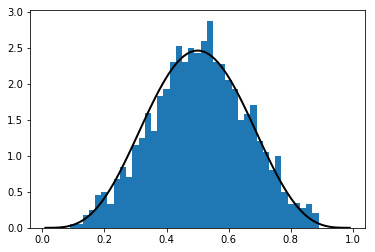

In [2]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

q = beta(5, 5)      # Beta(a, b), with a = b = 5
obs = q.rvs(2000)   # 2000 observations
grid = np.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots()
ax.hist(obs, bins=40, normed=True)                      # "normed=Ture" makes the integral over the range is one
ax.plot(grid, q.pdf(grid), 'k-', linewidth=2)
plt.show()

- **Note1:q = beta(5, 5)**    
> - Via the call, we created a so-called **rv_frozen** object    
>- The “frozen” part of the notation implies that q represents a particular distribution with a particular set of parameters    
>- Once we’ve done so, we can then generate random numbers, evaluate the density, etc., all from this fixed distribution    
just as **q.rvs(), q.pdf()** in the example

In [3]:
q.cdf(0.4)      # Cumulative distribution function

0.26656768000000003

In [4]:
q.pdf(0.4)      # Density function

2.0901888000000013

In [5]:
q.ppf(0.8)      # Quantile (inverse cdf) function

0.63391348346427079

In [6]:
q.mean()

0.5

- **Note2:** The general syntax for creating these objects is    
**identifier = scipy.stats.distribution_name(shape_parameters)**    
where *distribution_name* is one of the distribution names in scipy.stats

- **Note3:** There are also two keyword arguments, **loc** and **scale**, which following our example above, are called as    
**identifier = scipy.stats.distribution_name(shape_parameters, loc=c, scale=d)**      
These transform the original random variable X into **<font color=#DC143C>Y=c+dX</font>**    
The methods rvs, pdf, cdf, etc. are transformed accordingly

- **Note4:**　alternative way of calling the methods described above     
Instead of using **rv_frozen object:q=beta(5,5), q.rvs(),q.pdf()**    
we use **beta.rvs(5,5), beta.pdf(5,5)** directly

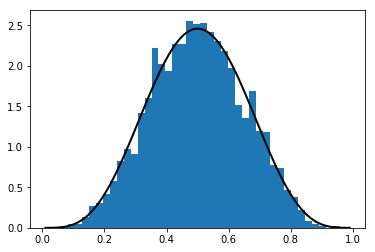

In [1]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

obs = beta.rvs(5, 5, size=2000)
grid = np.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots()
ax.hist(obs, bins=40, normed=True)
ax.plot(grid, beta.pdf(grid, 5, 5), 'k-', linewidth=2)
plt.show()

### 2. Other Goodies in scipy.stats

There are a variety statistical functions in **scipy.stats**

For example, ***scipy.stats.linregress*** implements simple linear regression

In [2]:
from scipy.stats import linregress

x = np.random.randn(200)
y = 2 * x + 0.1 * np.random.randn(200)
gradient, intercept, r_value, p_value, std_err = linregress(x, y)
gradient, intercept

(1.9938591820866292, -0.0050732331751419495)

## <div id="Outline 3"></div>[Roots and Fixed Points](https://docs.scipy.org/doc/scipy/reference/optimize.html)

### 1. What is root? 

A root of a real function $f$ on $[a,b]$ is an $x \in [a, b]$ such that $f(x)=0$

For example, if we plot the function

<center>$f(x) = \sin(4 (x - 1/4)) + x + x^{20} - 1$</center>

with $x\in[0,1]$ we get

0.40404040404


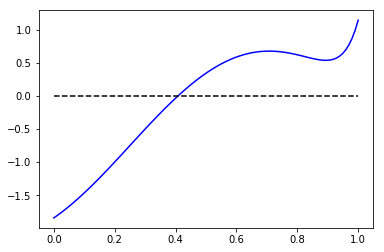

In [14]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x=np.linspace(0,1,100)
y=(np.sin(4*(x-1/4)))+x+(x**20)-1
ax.plot(x,y,'b-')
ax.plot(x,[0]*len(x),'k--')
plt.show()

From the figure, we can see the unique root is approximately 0.408

Let’s consider some numerical techniques for finding roots

### 2. Bisection

One of the most common algorithms for numerical root finding is **bisection**

**(1) What is [Bisection](https://en.wikipedia.org/wiki/Bisection_method)?**

To understand the idea, recall the well known game where    
- Player A thinks of a secret number between 1 and 100     
- Player B asks if it’s less than 50    
> If yes, B asks if it’s less than 25    
> If no, B asks if it’s less than 75    
- and so on    

This is bisection

**(2) Implementation of the algorithm in Python**

SciPy provides it’s own **[bisection function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.bisect.html#scipy.optimize.bisect)**

It works for all sufficiently **<font color=#DC143C>well behaved increasing continuous functions with $f(a) < 0 < f(b)$</font>**

In [15]:
from scipy.optimize import bisect

f = lambda x: np.sin(4 * (x - 0.25)) + x + x**20 - 1
bisect(f, 0, 1)

0.4082935042806639

### 3. The Newton-Raphson Method

Another very common root-finding algorithm is the **Newton-Raphson method**

**(1) What is [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method)?**

- A method for finding successively better approximations to the roots (or zeroes) of a real-valued function.

- The method starts with a function f defined over the real numbers x, the function's derivative f ′, and an **<font color=#DC143C>initial guess $x_{0}$ </font>**for a root of the function f.

- If the function satisfies the assumptions made in the derivation of the formula and the initial guess is close, then a better approximation $x_{1}$ is    
$x_{1}=x_{0}-\frac{f(x_{0})}{f'(x_{0})}$    
Geometrically, $(x_{1}, 0)$ is the intersection of the x-axis and the tangent of the graph of $f$ at $(x_{0}, f (x_{0}))$.

- The process is repeated as    
$x_{n+1}=x_{n}-\frac{f(x_{n})}{f'(x_{n})}$ 

- until a sufficiently accurate value is reached.

**(2) Implementation of the algorithm in Python**

In SciPy this algorithm is implemented by **[scipy.optimize.newton](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html#scipy.optimize.newton)**

**(3) Compare the Newton-Raphson method with Bisection method**

- Unlike bisection, the Newton-Raphson method uses local slope information

- This is a double-edged sword:    
> When the function is well-behaved, the Newton-Raphson method is faster than bisection    
> When the function is less well-behaved, the Newton-Raphson might fail

**(4) Investigate this using the same function $f$**

-  **Note1: Potential Instability**

In [16]:
from scipy.optimize import newton

newton(f, 0.2)   # Start the search at initial condition x = 0.2

0.40829350427935679

In [17]:
newton(f, 0.7)   # Start the search at x = 0.7 instead

0.70017000000002816

The second initial condition leads to failure of convergence

- **Note2: Newton can be much faster**

In [18]:
%timeit bisect(f, 0, 1)

10000 loops, best of 3: 99.3 µs per loop


In [19]:
%timeit newton(f, 0.2)

10000 loops, best of 3: 24.8 µs per loop


### 4. Hybrid Methods

So far we have seen that the Newton-Raphson method is fast but not robust

This bisection algorithm is robust but relatively slow

This illustrates a general principle:    
- If you have specific knowledge about your function, you might be able to exploit it to generate efficiency     
- If not, then the algorithm choice involves a **trade-off between speed of convergence and robustness**

In practice, most default algorithms for root finding, optimization and fixed points use **hybrid methods**

**(1) What is hybrid method?**

These methods typically combine a fast method with a robust method in the following manner:     
- Attempt to use a fast method     
- Check diagnostics    
- If diagnostics are bad, then switch to a more robust algorithm

**(2) Implementation of the algorithm in Python**

In scipy.optimize, the function **[brentq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html#scipy.optimize.brentq)** is such a hybrid method, and a good default

In [21]:
from scipy.optimize import brentq
brentq(f, 0, 1)

0.40829350427936706

- Note: $f$ must be continuous; $f(a)$ and $f(b)$ must have opposite signs.

In [22]:
%timeit brentq(f, 0, 1)

10000 loops, best of 3: 24.2 µs per loop


Here the correct solution is found and the speed is almost the same as newton

### 5. Multivariate Root Finding

Use **scipy.optimize.fsolve**, a wrapper for a hybrid method in MINPACK

Solve the following nonlinear equations using **fsolve**:

$5x_1 - 25 = 0$

$5x_0^2 - x_1 \cdot x_2 = 0$

$x_2 \cdot x_0 - 27 = 0$

In [16]:
from scipy.optimize import fsolve

def f(x):
    x0, x1, x2 = x.tolist()
    return [
        5*x1 - 25,
        5*x0**2 - x1*x2,
        x2*x0 - 27
    ]

r = fsolve(f, [1, 1, 1])
print(r)

[ 3.  5.  9.]


See the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) for more details

### 6. Fixed Points

**(1) What is fixed point?**

the fixed point of a function  $f$  is the root of  $g(x):=x−f(x)$

**(2) How to use SciPy to find the fixed points?**

SciPy has a function for finding (scalar) fixed points

In [23]:
from scipy.optimize import fixed_point

fixed_point(lambda x: x**2, 10.0)  # 10.0 is an initial guess

array(1.0)

If you don’t get good results, you can always switch back to the **brentq** root finder, since the fixed point of a function $f$ is the root of $g(x):=x−f(x)$

## <div id="Outline 4"></div>[Optimization](https://docs.scipy.org/doc/scipy/reference/optimize.html)

**(1) Minimization & Maximization**

- Most numerical packages provide only functions for minimization    
- Maximization can be performed by recalling that the maximizer of a function $f$ on domain D is the minimizer of $−f$ on D

**(2) Minimization & Root finding**

- Minimization is closely related to root finding: For smooth functions, interior optima correspond to roots of the first derivative

**(3) Speed/Robustness Trade-off in Optimization**

- The speed/robustness trade-off described above is present with numerical optimization too    
- Unless you have some prior information you can exploit, it’s usually best to use hybrid methods

**(4) Optimization Functions in SciPy**

- For constrained, univariate (i.e., scalar) minimization, a good hybrid option is **[fminbound](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fminbound.html#scipy.optimize.fminbound)**

In [24]:
from scipy.optimize import fminbound

fminbound(lambda x: x**2, -1, 2)  # Search in [-1, 2]

0.0

- Multivariate local optimizers include **minimize, fmin, fmin_powell, fmin_cg, fmin_bfgs, and fmin_ncg**    
- Constrained multivariate local optimizers include **fmin_l_bfgs_b, fmin_tnc, fmin_cobyla**

See the [documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html) for details

## <div id="Outline 5"></div>[Integration](https://docs.scipy.org/doc/scipy/reference/integrate.html)

Most numerical integration methods work by computing the integral of an approximating polynomial

The resulting error depends on how well the polynomial fits the integrand, which in turn depends on how “regular” the integrand is

In SciPy, the relevant module for numerical integration is **scipy.integrate**

A good default for univariate integration is **quad**

In [25]:
from scipy.integrate import quad

integral, error = quad(lambda x: x**2, 0, 1)
integral

0.33333333333333337

There are other options for univariate integration—a useful one is **fixed_quad**, which is fast and hence works well inside for loops

There are also functions for multivariate integration

See the [documentation](https://docs.scipy.org/doc/scipy/reference/integrate.html) for more details

## <div id="Outline 6"></div> [Linear Algebra](https://docs.scipy.org/doc/scipy/reference/linalg.html)

We saw that NumPy provides a module for linear algebra called **linalg**

SciPy also provides a module for linear algebra with the same name

The latter is not an exact superset of the former, but overall it has more functionality.The following example compute the inverse of a matrix using $inv$ function in **scipy.linalg** (which is also available in **numpy.linalg**) 

In [19]:
import scipy.linalg as la
m1 = np.mat('-2 1; 4 -3')
m2 = la.inv(m1)
print(m2)
print(m1*m2)

[[-1.5 -0.5]
 [-2.  -1. ]]
[[ 1.  0.]
 [ 0.  1.]]


We leave you to investigate the abundant and powerful set of [available routines](https://docs.scipy.org/doc/scipy/reference/linalg.html)

## Take-away

- SciPy is built on top of NumPy    
- **scipy.stats**     
> numerous random variable objects (densities, cumulative distributions, random sampling, etc.)    
some estimation procedures    
some statistical tests
- **scipy.optimize**      
> root finding    
> fixed point     
> optimization
- **sicpy.integrate**       
> numerical integration
- **sicpy.linalg**    
> linear algebra

## <div id="Outline 7"></div>Exercises

### 1. For the linear regression example code in the lecture, change the parameters and we have the following code:

In [21]:
import numpy as np
from scipy.stats import linregress

x = np.random.randn(20)
y = 2 * x + 0.5 * np.random.randn(20)
gradient, intercept, r_value, p_value, std_err = linregress(x, y)
gradient, intercept

(1.8982453536006563, 0.0164862752857447)

Please plot the samples and the linear regression function like below

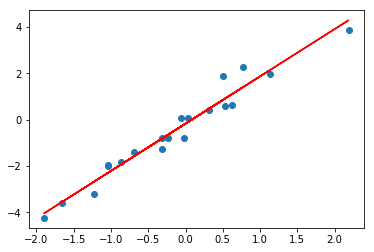

In [20]:
# a plot for a linear regression

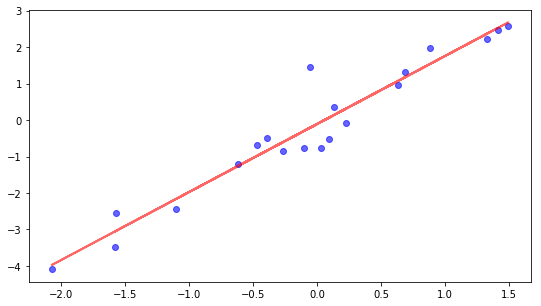

In [27]:
# Exercise 1

import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 5))

x = np.random.randn(20)
y = 2 * x + 0.5 * np.random.randn(20)
gradient, intercept, r_value, p_value, std_err = linregress(x, y)
gradient, intercept

f = lambda x: gradient * x + intercept

ax.plot(x, y, 'bo', lw=2, alpha=0.6)
ax.plot(x, f(x), 'r-', lw=2, alpha=0.6)
plt.show()

### 2. Given a function: 
$f(x) = x^2 - 3x + 7$

Suppose we know an $x_0$ which makes $f(x_0) = 385$, please get the value of $x_0$

**Hint:** You may use *multivariate root finding* introduced in the lecture for solving this problem.

In [19]:
# Exercise 2

from scipy.optimize import brentq

solution = brentq(lambda x: x**2 - 3 * x + 7 - 385, 1e-5, 30)

print(solution)

solution2 = brentq(lambda x: x**2 - 3 * x + 7 - 385, -18, 1e-5)
print(solution2)

21.0
-18.0


###  3. Write a recursive implementation of the bisection function described above

- **recusive function calls**: a function that calls itself

In [76]:
from scipy.optimize import bisect

f = lambda x: np.sin(4 * (x - 0.25)) + x + x**20 - 1
bisect(f, 0, 1)


def bisection(f, a, b, tol=10e-5):

    lower, upper = a, b
    if upper - lower < tol:
        return 0.5 * (upper + lower)
    else:
        middle = 0.5 * (upper + lower)
        print('Current mid point = {}'.format(middle))
        if f(middle) > 0:   
            bisection(f, lower, middle)
        else:               
            bisection(f, middle, upper)